In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson, halfnorm
from scipy.ndimage import gaussian_filter
from copy import copy
import multiprocessing 
import pandas as pd
%load_ext line_profiler

# Particle filtering approaches for decoding
Here, we want to demonstrate on *artificial* data, how to decode a position with particle filtering approaches. In analogy to the real data we are facing with, we will consider a grid-like representation of the place fields. Currently, the whole demonstration has
* 1D, i.e. on a line
* no fit of the actual mouse dynamics

## Generating artificial data

### Mouse trajectories
For the mouse trajectories, we consider an integrated random walk model with reflecting boundary conditions.

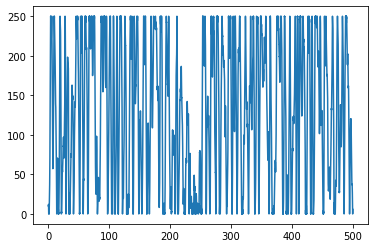

In [21]:
T = 500
dt = 0.01
t = np.arange(0,T,dt)
M = 5 # number of neurons
L = 250 # total length
dL = 0.1
xaxis = np.arange(0,L,dL) + dL/2 # center of bins

params = {
    "tau": 10,
    "q": 100,
    "box": np.array([0,L]),
    "dt": dt,
    "xaxis": xaxis, # axis for placefields
    "dL": dL
}

def fn(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]


X = np.zeros((int(T/dt),2)) # x and v components
X[0,0] = 10
X[0,1] = 0 
for i in np.arange(1,int(T/dt)):
    x = np.copy(X[i-1,0])
    v = np.copy(X[i-1,1])
    # integrate one timestep using Euler scheme
    X[i,0] = x + v * dt
    X[i,1] = v - 1/params["tau"] * v * dt + params["q"] * np.random.normal(0,np.sqrt(dt))
    # implement Skohorod boundary conditions
    if X[i,0] < 0:
        X[i,0] = 0 # put particle to boundary
        X[i,1] = 0 # set velocity to zero
    elif X[i,0] > L:
        X[i,0] = L # put particle to boundary
        X[i,1] = 0 # set velocity to zero
        
find_nearest = np.vectorize(lambda x: fn(xaxis, x))
X[:,0] = find_nearest(X[:,0])
        
plt.plot(t,X[:,0])
plt.show()

### Place fields
We consider a linear maze of 250 cm length and randomly generate some place fields.

In [22]:
def generatePlaceFields1D(N,xaxis,L):
    # N: number of neurons
    # L: length of the linear track
    # dL: spatial discretization
    
    
    L = abs(xaxis[-1]-xaxis[0])
    dL = xaxis[1]-xaxis[0]
    f = np.zeros((N,xaxis.size))
    for i in range(N):
        # draw place field parameters randomly
        m = np.random.poisson(1) + 1   # number of place fields
        mu = np.random.uniform(xaxis.min(),xaxis.max(),m)  # place field centers
        sigma = np.random.uniform(dL,L/4,m) # place field width
        f0 = np.random.uniform(0,10,m) # maximal firing rate
        for j in range(m):
            f[i] = f[i] + f0[j] * np.exp(-(xaxis-mu[j])**2/sigma[j]**2)
    
    return f

In [23]:
def h(x,f,xaxis,dL):
# evaluates the place fields on a grid
# returns spiking frequencies at respective locations from x
    bins = xaxis-dL/2
    ind = np.digitize(x,bins) - 1
    hx = f[:,ind]
    
    return hx
    
    
def poisson_mean(spikes, i, x_k, x, time_bucket_length):
    if len(np.where(x==x_k)[0]) > 0:
        return spikes[np.where(x==x_k),i].sum()/(len(np.where(x==x_k)[0]) * time_bucket_length)
    return 0

def calculate_poisson(spikes, x, xaxis, time_bucket_length):
    poisson = {}
    num_neurons = spikes.shape[1]
    for x_k in xaxis:
        for i in range(num_neurons):
            pm = poisson_mean(spikes, i, x_k, x, time_bucket_length)
            poisson[i, x_k] = pm
    return poisson

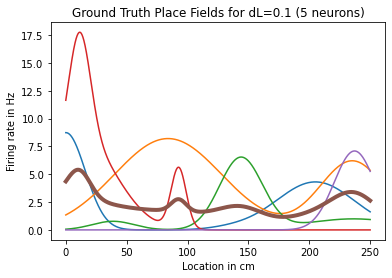

In [24]:
f = generatePlaceFields1D(M,xaxis,L)
params["f"] = f
plt.plot(xaxis,np.transpose(f))
plt.plot(xaxis,np.sum(f,0)/M,linewidth=4)
plt.title("Ground Truth Place Fields for dL={} ({} neurons)".format(dL, M))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

### Combine mouse trajectories with spikes

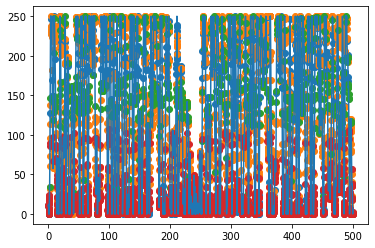

In [25]:
H = h(X[:,0],f,xaxis,dL)
dN = np.random.poisson(H * dt)
plt.plot(t,X[:,0])
# only plot three sample cells
for i in np.arange(4):
    plt.scatter(t,np.where(dN[i,:]>0,X[:,0],np.nan))
plt.show()

## Reconstructing Place Fields 

In [26]:
def estimate_place_fields(spikes, X, xaxis, dt, sigma=25):
    poisson_dict = calculate_poisson(spikes, X, xaxis, dt)
    poisson_series = pd.Series(poisson_dict).reset_index()
    poisson_series.columns = ['neuron', 'location', 'poisson_mean']
    poisson_series = poisson_series.sort_values(['neuron', 'location']).reset_index(drop=True)
    estimated_place_fields = np.array(poisson_series.pivot(index='neuron',columns='location'))
    smoothed_place_fields = np.apply_along_axis(lambda x: gaussian_filter(x, sigma=sigma), 1, estimated_place_fields)
    return estimated_place_fields, smoothed_place_fields

In [27]:
spikes = dN.transpose()
X[:,0] = np.around(X[:,0],2)
xaxis = np.around(xaxis,2)
estimated_place_fields, smoothed_place_fields = estimate_place_fields(spikes, X[:,0], xaxis, dt)
params["estimated_place_fields"] = estimated_place_fields
params["smoothed_place_fields"] = smoothed_place_fields

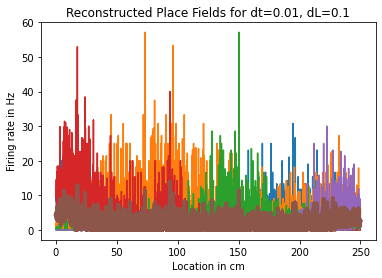

In [28]:
plt.plot(xaxis,np.transpose(estimated_place_fields))
plt.plot(xaxis,np.sum(estimated_place_fields,0)/M,linewidth=4)
plt.title("Reconstructed Place Fields for dt={}, dL={}".format(dt, dL))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

In [29]:
place_field_difference = abs(f - estimated_place_fields)
total_err = place_field_difference.sum()
mean_err = place_field_difference.mean()
print("Reconstructed PF: total error is {}, mean error is {}".format(total_err, mean_err))

Reconstructed PF: total error is 26779.690492175203, mean error is 2.142375239374016


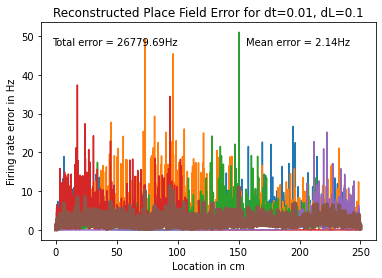

In [30]:
plt.plot(xaxis,np.transpose(place_field_difference))
plt.plot(xaxis,np.sum(place_field_difference,0)/M,linewidth=4)
plt.title("Reconstructed Place Field Error for dt={}, dL={}".format(dt, dL))
plt.ylabel("Firing rate error in Hz")
plt.xlabel("Location in cm")
plt.figtext(0.15,0.8,"Total error = {:.2f}Hz".format(total_err))
plt.figtext(0.6,0.8,"Mean error = {:.2f}Hz".format(mean_err))
plt.show()

The reconstruction of place fields with small $dt<<1$ does not go well, because with $f_{i,x_k}dt<1$ where $f_i$ is the firing rate of neuron $i$ at location $x_k$, the MLE for the Poisson distribution has high variance (dependent on the actual spikes generated). This appears as strong discontinuities in our estimate for $f_i$. One solution is some form of continuity constraint on $f_i$, fitting a curve to $f_i$, or assuming something about the underlying distribution $f_i$.

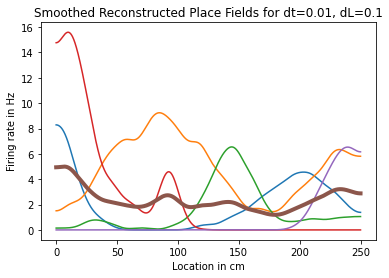

In [34]:
estimated_place_fields, smoothed_place_fields = estimate_place_fields(spikes, X[:,0], xaxis, dt, sigma=250/4)
plt.plot(xaxis,np.transpose(smoothed_place_fields))
plt.plot(xaxis,np.sum(smoothed_place_fields,0)/M,linewidth=4)
plt.title("Smoothed Reconstructed Place Fields for dt={}, dL={}".format(dt, dL))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

In [35]:
smoothed_difference = abs(f - smoothed_place_fields)
total_err = smoothed_difference.sum()
mean_err = smoothed_difference.mean()
print("Smoothed PF: total error is {}, mean error is {}".format(total_err, mean_err))

Smoothed PF: total error is 2285.3354893966894, mean error is 0.18282683915173514


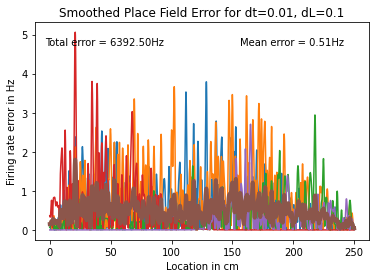

In [14]:
plt.plot(xaxis,np.transpose(smoothed_difference))
plt.plot(xaxis,np.sum(smoothed_difference,0)/M,linewidth=4)
plt.title("Smoothed Place Field Error for dt={}, dL={}".format(dt, dL))
plt.ylabel("Firing rate error in Hz")
plt.xlabel("Location in cm")
plt.figtext(0.15,0.8,"Total error = {:.2f}Hz".format(total_err))
plt.figtext(0.6,0.8,"Mean error = {:.2f}Hz".format(mean_err))
plt.show()

## Filtering
### Bootstrap Particle filter
Now that we have some example place field data, we can implement a particle filter that is using the ground truth model.

In [15]:
def resample(x,w,N):
    x_r = np.random.choice(x, p=w, size=N)
    w_r = np.ones(N) * (1.0/N)
    return x_r,w_r

def BPF(X,w,dN,params):
    # implements a simple Bootstrap Particle filter with the prior transition probability as the proposal
    P = X.shape[0]
    
    # prediction
    X_out = np.copy(X)
    x = np.copy(X[:,0])
    v = np.copy(X[:,1])
    # integrate one timestep using Euler scheme
    X_out[:,0] = x + v * dt
    X_out[:,1] = v - 1/params["tau"] * v * dt + params["q"] * np.random.normal(0,np.sqrt(params["dt"]),P)
    
    # implement Skohorod boundary conditions
    if "box" in params:
        #left border
        X_out[:,1] = np.where(X_out[:,0]<params["box"][0],0,X_out[:,1])
        X_out[:,0] = np.where(X_out[:,0]<params["box"][0],params["box"][0],X_out[:,0])
        # right border
        X_out[:,1] = np.where(X_out[:,0]>params["box"][1],0,X_out[:,1])
        X_out[:,0] = np.where(X_out[:,0]>params["box"][1],params["box"][1],X_out[:,0])

    
    # update (importance weights)
    # currently only dependent on position, not on velocity
    dN = np.transpose(np.tile(dN,(P,1)))
    w_out = w * np.prod( poisson.pmf(dN,h(X_out[:,0],f,xaxis,params["dL"])*dt) , 0 )
    w_out = w_out / np.sum(w_out)
    # resampling step
    if "Peff_min" in params:
        Peff = 1/np.sum(w_out**2)
        if Peff/P < params["Peff_min"]:
            X_out = X_out[np.random.choice(X_out.shape[0],P,p=w_out)]
            w_out = 1/P * np.ones(w_out.shape)
    
    return (X_out,w_out)

#### Run the particle filter

In [16]:
P = 1000
params["Peff_min"] = 0.5
X_PF = np.zeros((int(T/dt),P,2))
X_PF[0,:,0] = np.random.uniform(low=params["box"][0],high=params["box"][1],size=P)
w_PF = np.zeros((int(T/dt),P))
w_PF[0] = 1/P
# propagate particles
for i in range(1,int(T/dt)):
    X_PF[i],w_PF[i] = BPF(X_PF[i-1],w_PF[i-1],dN[:,i],params)

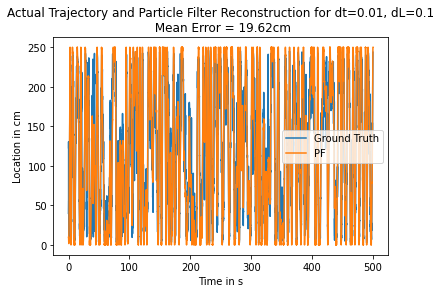

In [17]:
mu = np.sum(X_PF[:,:,0]*w_PF,1)

H = h(X[:,0],f,xaxis, dL)
dN = np.random.poisson(H * dt)
plt.plot(t,mu)
plt.plot(t,X[:,0])
# only plot three sample cells
# for i in np.array([0]):
#     plt.scatter(t,np.where(dN[i,:]>0,X[:,0],np.nan))
plt.title("Actual Trajectory and Particle Filter Reconstruction for dt={}, dL={}\n Mean Error = {:.2f}cm".format(dt, dL, abs(mu-X[:,0]).mean()))
plt.legend(['Ground Truth', 'PF'])
plt.ylabel("Location in cm")
plt.xlabel("Time in s")
plt.show()

## BPF With Reconstructed Place Fields

In [18]:
def BPF_recon(X,w,dN,params):
    # implements a simple Bootstrap Particle filter with the prior transition probability as the proposal
    P = X.shape[0]
    
    # prediction
    X_out = np.copy(X)
    x = np.copy(X[:,0])
    v = np.copy(X[:,1])
    # integrate one timestep using Euler scheme
    X_out[:,0] = x + v * dt
    X_out[:,1] = v - 1/params["tau"] * v * dt + params["q"] * np.random.normal(0,np.sqrt(params["dt"]),P)
    
    # implement Skohorod boundary conditions
    if "box" in params:
        #left border
        X_out[:,1] = np.where(X_out[:,0]<params["box"][0],0,X_out[:,1])
        X_out[:,0] = np.where(X_out[:,0]<params["box"][0],params["box"][0],X_out[:,0])
        # right border
        X_out[:,1] = np.where(X_out[:,0]>params["box"][1],0,X_out[:,1])
        X_out[:,0] = np.where(X_out[:,0]>params["box"][1],params["box"][1],X_out[:,0])

    
    # update (importance weights)
    # currently only dependent on position, not on velocity
    dN = np.transpose(np.tile(dN,(P,1)))
    w_out = w * np.prod( poisson.pmf(dN,h(X_out[:,0],params["smoothed_place_fields"],xaxis,params["dL"])*dt) , 0 )
    w_out = w_out / np.sum(w_out)
    # resampling step
    if "Peff_min" in params:
        Peff = 1/np.sum(w_out**2)
        if Peff/P < params["Peff_min"]:
            X_out = X_out[np.random.choice(X_out.shape[0],P,p=w_out)]
            w_out = 1/P * np.ones(w_out.shape)
    
    return (X_out,w_out)

### Run PF

In [19]:
X_rPF = np.zeros((int(T/dt),P,2))
X_rPF[0,:,0] = np.random.uniform(low=params["box"][0],high=params["box"][1],size=P)
w_rPF = np.zeros((int(T/dt),P))
w_rPF[0] = 1/P
# propagate particles
for i in range(1,int(T/dt)):
    X_rPF[i],w_rPF[i] = BPF_recon(X_rPF[i-1],w_rPF[i-1],dN[:,i],params)

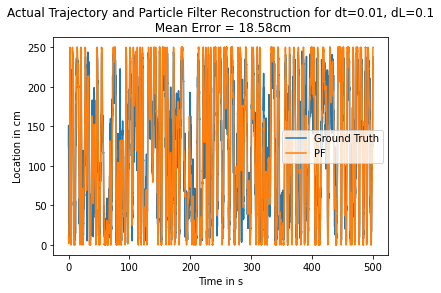

In [20]:
mu = np.sum(X_rPF[:,:,0]*w_rPF,1)

H = h(X[:,0],f,xaxis, dL)
dN = np.random.poisson(H * dt)
plt.plot(t,mu)
plt.plot(t,X[:,0])
plt.title("Actual Trajectory and Particle Filter Reconstruction for dt={}, dL={}\n Mean Error = {:.2f}cm".format(dt, dL, abs(mu-X[:,0]).mean()))
plt.legend(['Ground Truth', 'PF'])
plt.ylabel("Location in cm")
plt.xlabel("Time in s")
plt.show()